In [24]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.stats as stats
import xgboost as xgb
import pandas as pd 
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler , FunctionTransformer, PowerTransformer, KBinsDiscretizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

In [25]:
df= pd.read_csv('/home/devil/DL/CDC_Project/train(1)(train(1)).csv')
df.info()
df['age'] = 2015 - df['yr_built']
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
df['basement_present'] = (df['sqft_basement'] > 0).astype(int)
df['living_lot_ratio'] = df['sqft_living'] / df['sqft_lot']
df['years_since_renovation'] = np.where(
    df['yr_renovated'] > 0,
    2015 - df['yr_renovated'],
    0
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

/tmp/ipykernel_245087/3374174183.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


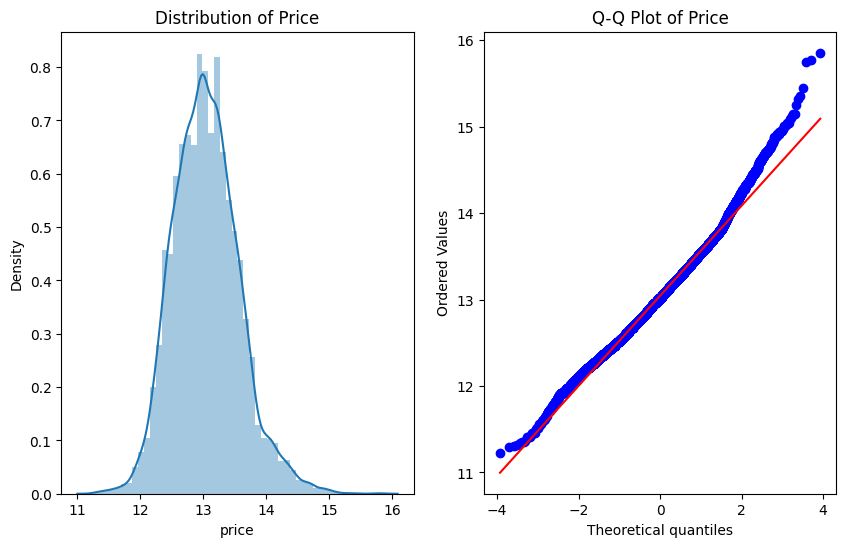

In [26]:
ttf = FunctionTransformer(func=np.log1p)
df['price']= ttf.fit_transform(df[['price']]) 
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.distplot(df['price'])
plt.title('Distribution of Price')

plt.subplot(122)
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Price')
plt.show()

In [27]:
# df['price'].describe()
# sns.boxplot(df['price'])
# Q1 = df['price'].quantile(0.25)
# Q3 = df['price'].quantile(0.75)
# IQR = Q3 - Q1
# lower = Q1 - 1.5 * IQR
# upper = Q3 + 1.5 * IQR
# df = df[(df['price'] >= lower) & (df['price'] <= upper)]

In [29]:
X = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','lat','long','view','condition','grade','sqft_basement','basement_present','age','is_renovated','living_lot_ratio','years_since_renovation','sqft_living15','sqft_lot15']]
y = df[['price']]


Dropped due to correlation: []
sqft_basement  basement_present          0.822140
is_renovated   years_since_renovation    0.774096
sqft_living    grade                     0.760925
               sqft_living15             0.754931
bathrooms      sqft_living               0.751945
sqft_lot       sqft_lot15                0.720981
grade          sqft_living15             0.707371
dtype: float64


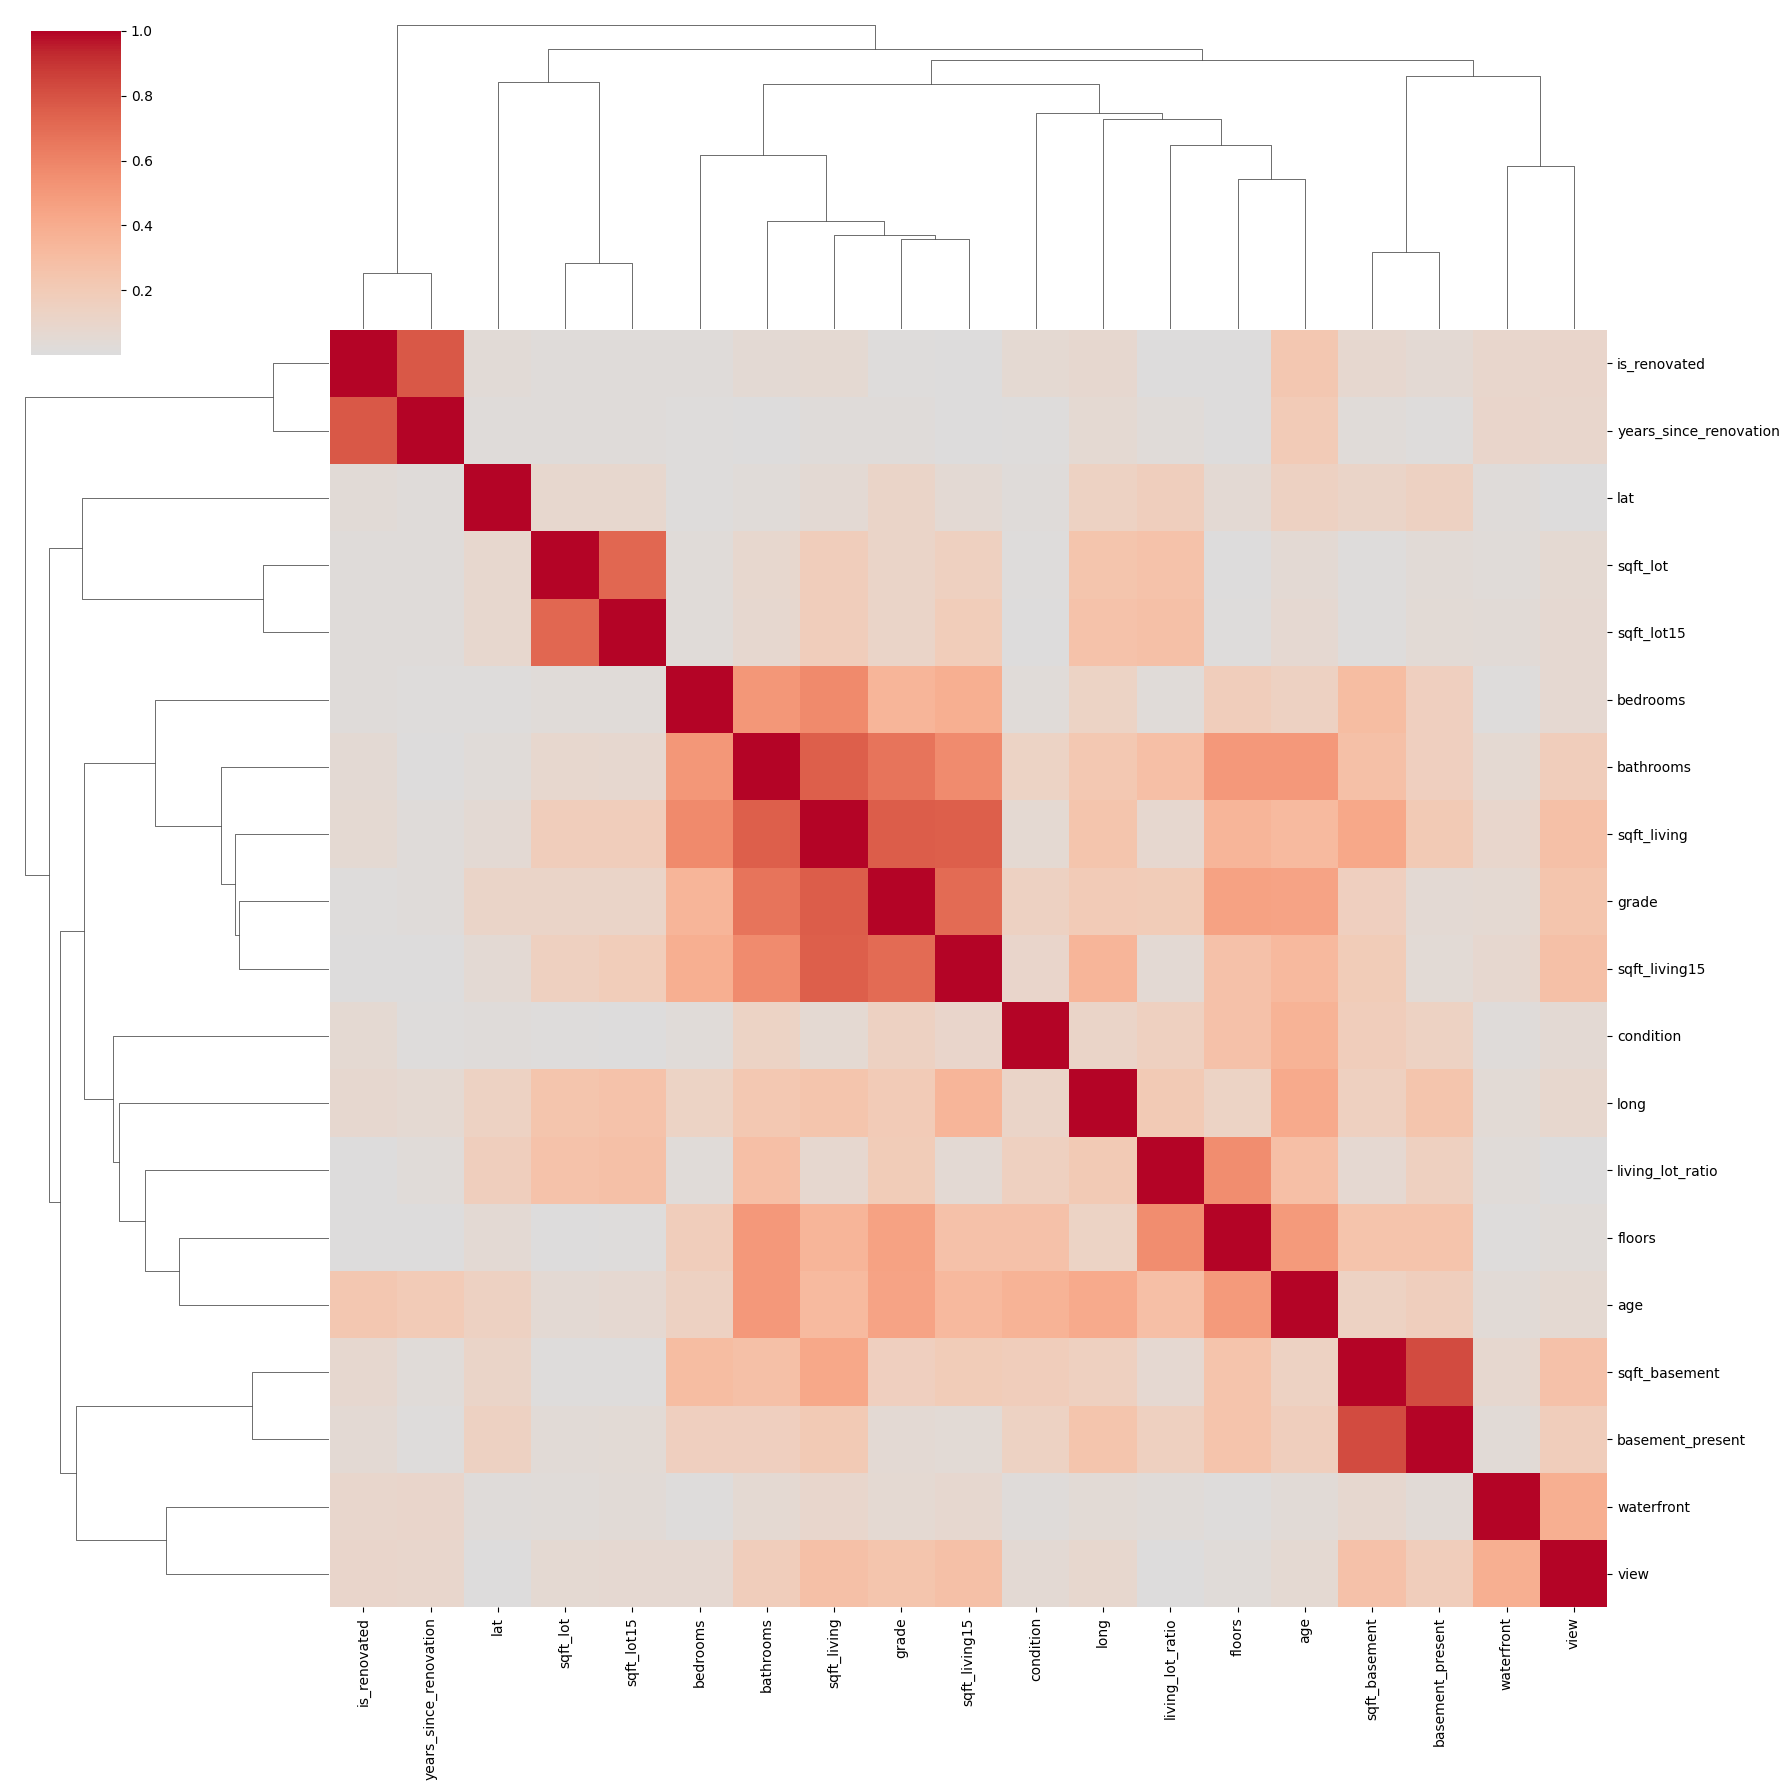

In [30]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X = X.drop(columns=to_drop)
print("Dropped due to correlation:", to_drop)
threshold = 0.7

high_corr = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

high_corr = high_corr[high_corr > threshold]
print(high_corr)
sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    figsize=(18, 18)
)
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) 

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Covariance Matrix:
 [[ 8.26367820e+18 -1.10689532e+07  1.45634025e+07]
 [-1.10689532e+07  2.74450054e-01  1.65091268e-01]
 [ 1.45634025e+07  1.65091268e-01  8.70993034e-01]]
Eigen Values:
 [8.26367820e+18 2.31784568e-01 9.13618028e-01]
Eigen Vectors:
 [[-1.00000000e+00  1.73767131e-12  1.37131996e-12]
 [ 1.33947050e-12  9.68218519e-01 -2.50105776e-01]
 [-1.76233902e-12 -2.50105776e-01 -9.68218519e-01]]
[0.23157811 0.3687369  0.48433672 0.57993745 0.64595359 0.70642385
 0.75834675 0.80458288 0.84054649 0.87588299 0.90203748 0.92105141
 0.93688091 0.95124307 0.96363609 0.97515354 0.98554765 0.99498793
 1.        ]


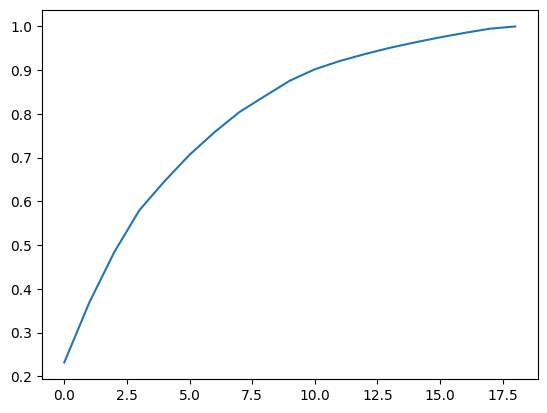

In [ ]:
pca = PCA(n_components=None)
X_train_trf = pca.fit_transform(X_train_scaled)
X_test_trf = pca.transform(X_test_scaled)
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 3:
    cov_input = numeric_df.iloc[:, :3].apply(pd.to_numeric, errors='coerce').dropna()
    covariance_matrix = np.cov(cov_input.T)
else:
    covariance_matrix = np.cov(X_train_scaled.T)

print('Covariance Matrix:\n', covariance_matrix)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print('Eigen Values:\n', eigen_values)
print('Eigen Vectors:\n', eigen_vectors)
dt = np.cumsum(pca.explained_variance_ratio_)
print(dt)
plt.plot(dt)
plt.show()

In [34]:
# pca = PCA(n_components=10)
# X_train_scaled = pca.fit_transform(X_train_scaled)
# X_test_scaled = pca.transform(X_test_scaled)

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train.values.ravel())
print(model.score(X_test_scaled,y_test))
print(model.score(X_train_scaled,y_train))

0.7828888057566683
0.7712104457486023


Test R² Score: 0.8941
Train R² Score: 0.9057

Regression Metrics (per output):
------------------------------------------------------------
price:
  MSE: 0.0292 | MAE: 0.1250 | R²: 0.8941
------------------------------------------------------------
Average MSE: 0.0292
Average MAE: 0.1250
Average R²: 0.8941


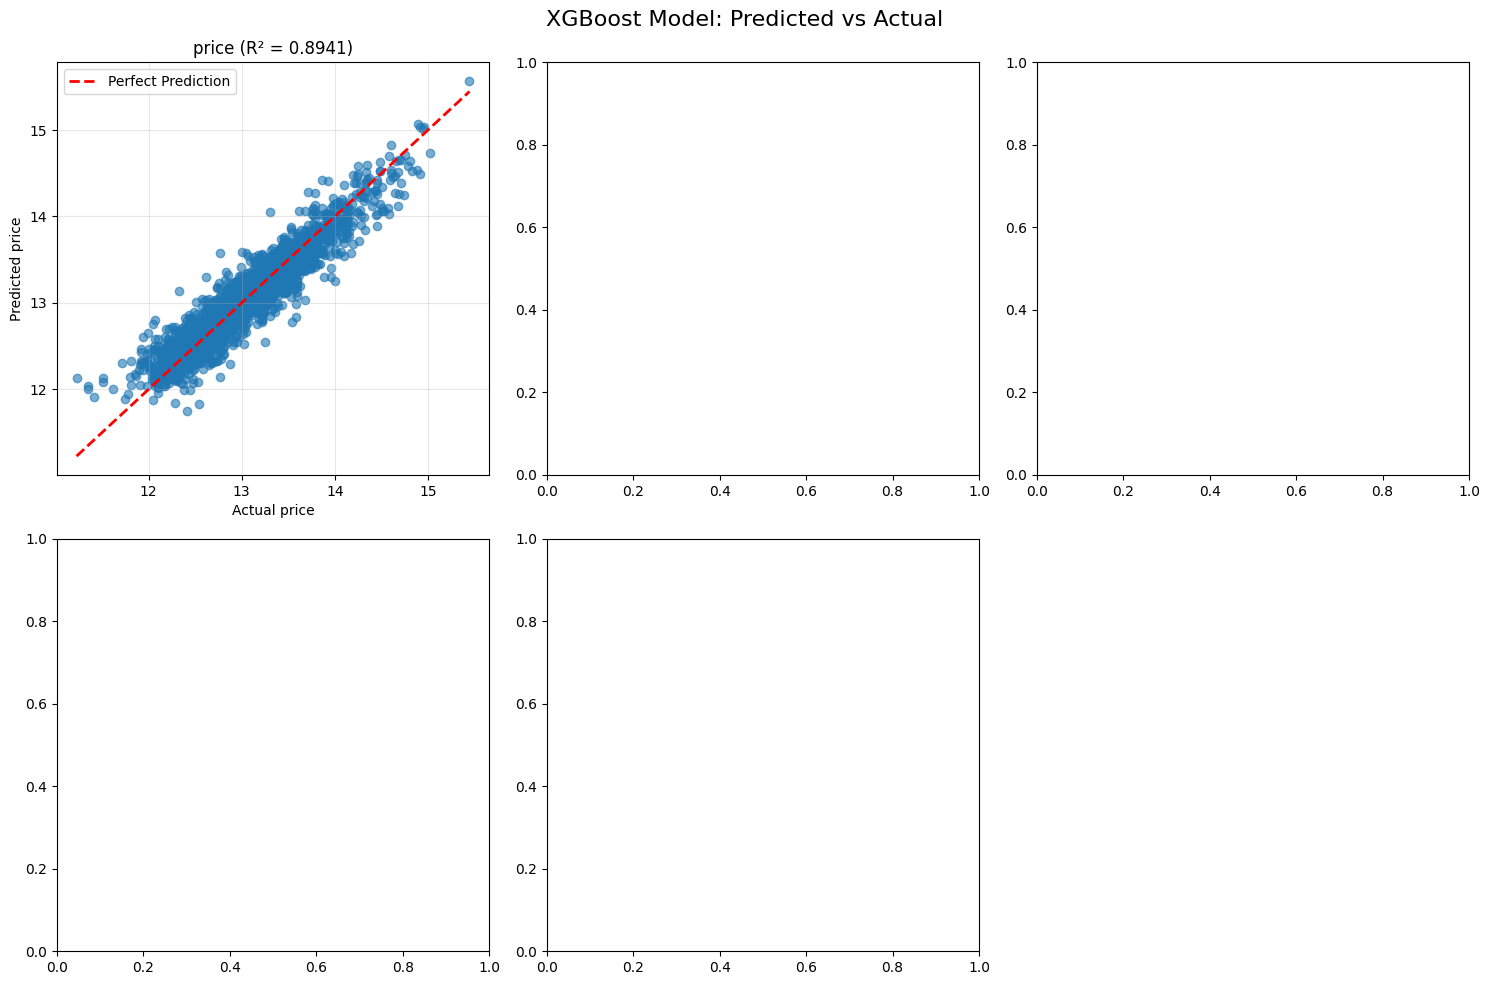

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# model = xgb.XGBRegressor(objective='reg:squarederror')

# param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'max_depth': [3, 4, 5, 6],
#     'min_child_weight': [1, 3, 5, 7, 10],
#     'subsample': [0.6, 0.7, 0.8, 0.9],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
#     'gamma': [0, 0.1, 0.3, 0.5, 1],
#     'reg_alpha': [0, 0.1, 0.5, 1],
#     'reg_lambda': [1, 2, 3, 5]
# }

# search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=50,            # try 50 random combinations
#     cv=5,                 # 5-fold cross validation
#     scoring='r2',
#     verbose=2,
#     n_jobs=-1
# )

# search.fit(X_train_scaled, y_train)

# print("Best Params:", search.best_params_)
# print("Best CV Score:", search.best_score_)



modelxg = (xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=1,
    subsample=0.6,
    colsample_bytree=0.9,
    reg_alpha=0,
    reg_lambda=2,
    gamma=0.3,
    random_state=42
))
modelxg.fit(X_train_scaled, y_train)
test_score = modelxg.score(X_test_scaled, y_test)
train_score = modelxg.score(X_train_scaled, y_train)
print(f"Test R² Score: {test_score:.4f}")
print(f"Train R² Score: {train_score:.4f}")

# y_train_pred = cross_val_predict(model, X_train_scaled, y_train, cv=5)
# print(confusion_matrix(y_train,y_train_pred))

# h=model.history
# plt.plot(h.history['loss'])
# plt.plot(h.history['val_loss'])
# # plt.show()
y_predicted = modelxg.predict(X_test_scaled)
if y_predicted.ndim == 1:
    y_predicted = y_predicted.reshape(-1, 1)

print("\nRegression Metrics (per output):")
print("-" * 60)

mse_scores = []
mae_scores = []
r2_scores = []

for i, col_name in enumerate(y_test.columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_predicted[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_predicted[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_predicted[:, i])
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    print(f"{col_name}:")
    print(f"  MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("-" * 60)
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('XGBoost Model: Predicted vs Actual', fontsize=16)

for i, col_name in enumerate(y_test.columns):
    ax = axes[i // 3, i % 3]
    ax.scatter(y_test.iloc[:, i], y_predicted[:, i], alpha=0.6)
    ax.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
            [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
            'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel(f'Actual {col_name}')
    ax.set_ylabel(f'Predicted {col_name}')
    ax.set_title(f'{col_name} (R² = {r2_scores[i]:.4f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [37]:
# from sklearn.ensemble import BaggingRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import GridSearchCV

# params = {
#     # Base estimator
#     'estimator': [
#         KNeighborsRegressor()
#     ],

#     # Bagging parameters
#     'n_estimators': [20, 50, 100, 200],
#     'max_samples': [0.6, 0.8, 1.0],
#     'max_features': [0.6, 0.8, 1.0],
#     'bootstrap': [True],

#     # KNN parameters
#     'estimator__n_neighbors': [3, 5, 7, 11, 15],
#     'estimator__weights': ['uniform', 'distance'],
#     'estimator__p': [1, 2]   # 1=Manhattan, 2=Euclidean
# }

# bagging = BaggingRegressor(
#     random_state=1,
#     n_jobs=-1
# )
# random_search = RandomizedSearchCV(
#     estimator=bagging,
#     param_distributions=params,
#     n_iter=40,
#     cv=3,
#     scoring='r2',
#     n_jobs=-1,
#     random_state=1,
#     verbose=1
# )

# random_search.fit(X_train_scaled, y_train)
# print("Best CV R²:", random_search.best_score_)
# print("Best params:", random_search.best_params_)

# best_model = random_search.best_estimator_

# print("Train R²:", best_model.score(X_train_scaled, y_train))
# print("Test  R²:", best_model.score(X_test_scaled, y_test))

Training with early stopping...
------------------------------------------------------------
Training output 1/1 (price)... [LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.004558703250838834, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004558703250838834
[LightGBM] [Warning] feature_fraction is set=0.8618026725746952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8618026725746952
[LightGBM] [Warning] lambda_l2 is set=5.480456499617466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.480456499617466
[LightGBM] [Warning] lambda_l1 is set=2.518600387910156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.518600387910156
[LightGBM] [Warning] bagging_fraction is set=0.8249529843611099, subsam

/home/devil/DL/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/devil/DL/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/devil/DL/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


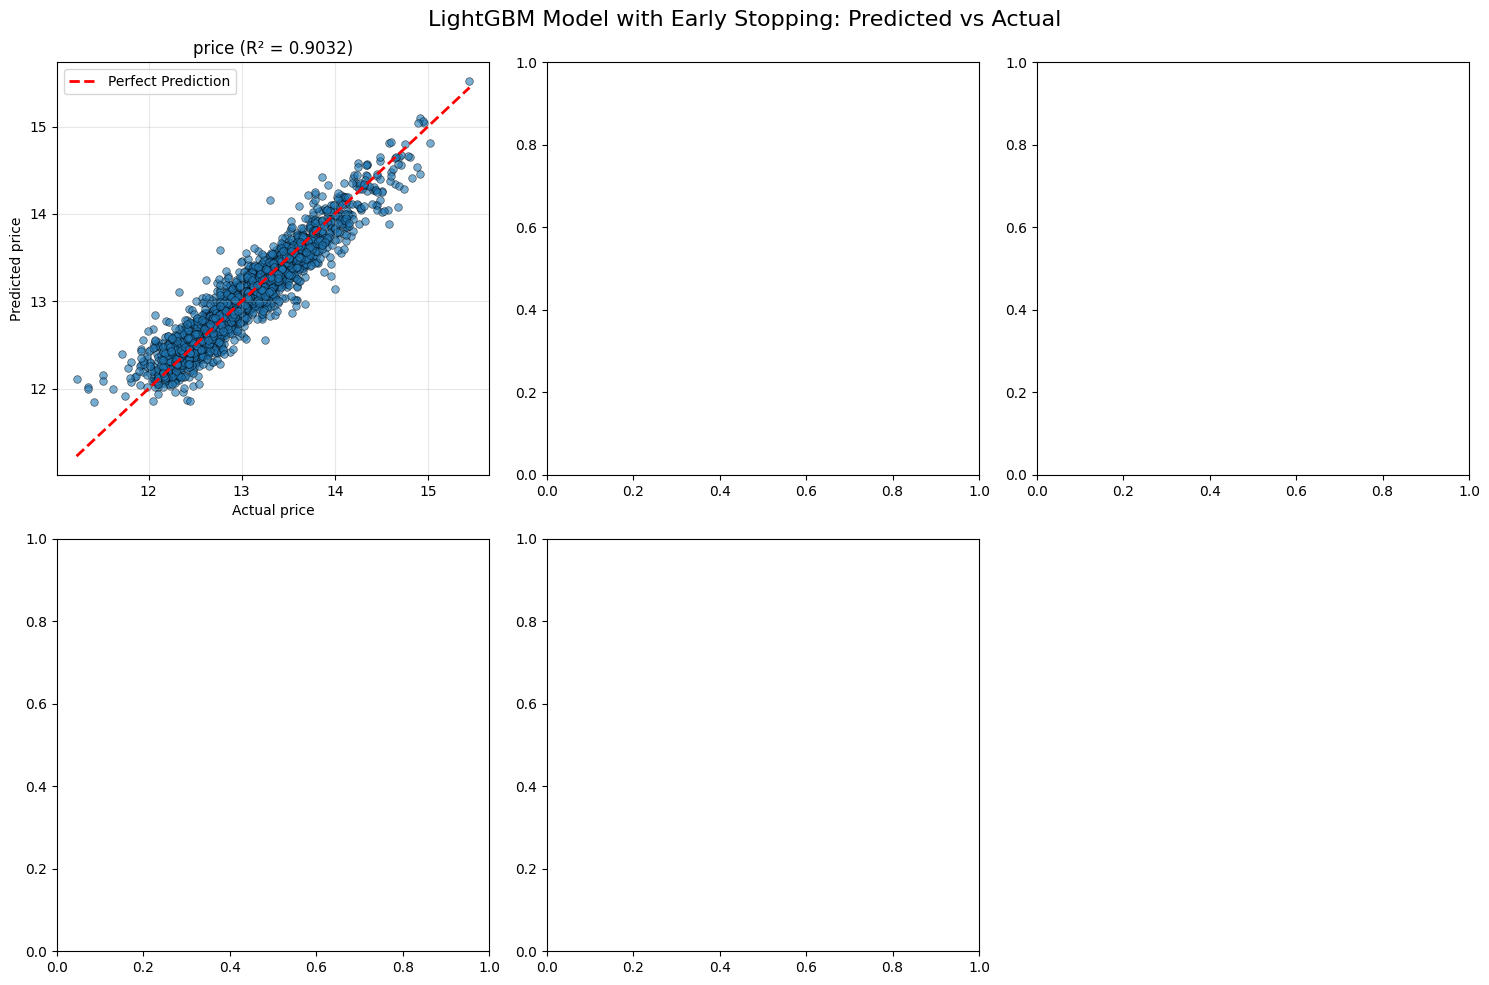


Feature Importance (First Output - price):
Feature 6: 2411.0000
Feature 7: 2251.0000
Feature 2: 1166.0000
Feature 13: 1136.0000
Feature 17: 871.0000
Feature 18: 835.0000
Feature 3: 824.0000
Feature 15: 816.0000
Feature 10: 415.0000
Feature 11: 362.0000


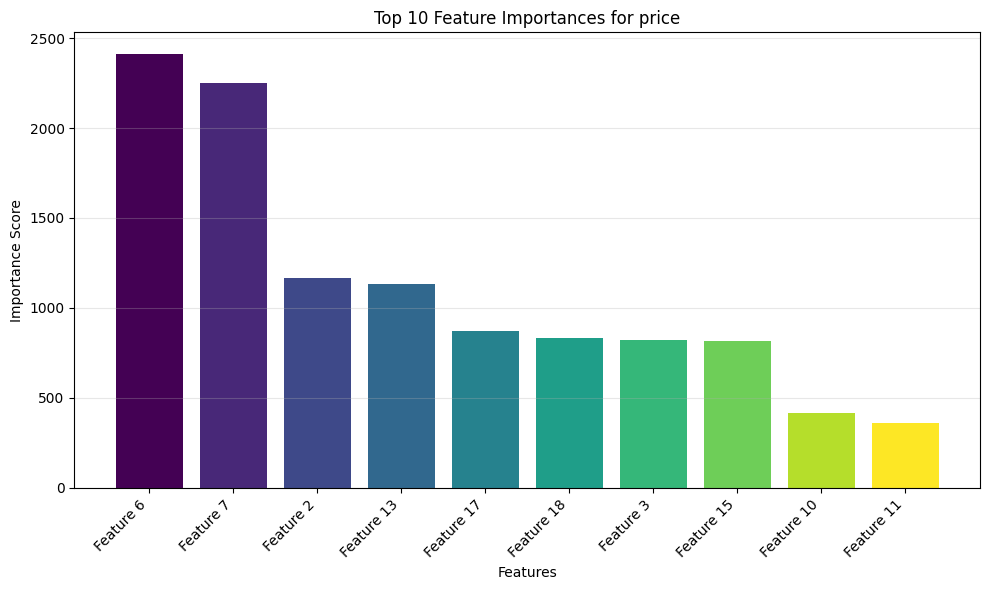


Early Stopping Summary:
price: Used 997/1000 iterations

Average iterations used: 997


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import lightgbm as lgb

base_estimator = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05544027799774911,
    max_depth=4,
    num_leaves=28,
    min_data_in_leaf=20,
    feature_fraction=0.8618026725746952,
    bagging_fraction=0.8249529843611099,
    bagging_freq=2,
    lambda_l1=2.518600387910156,
    lambda_l2=5.480456499617466,
    min_gain_to_split=0.004558703250838834,
    random_state=42
)

trained_estimators = []
for i in range(y_train.shape[1]):
    print(f"Training output {i+1}/{y_train.shape[1]} ({y_train.columns[i]})...", end=" ")

    model = LGBMRegressor(**base_estimator.get_params())

    model.fit(
        X_train_scaled, 
        y_train.iloc[:, i],
        eval_set=[(X_test_scaled, y_test.iloc[:, i])],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    trained_estimators.append(model)
    print(f"✓ Best iteration: {model.best_iteration_}")

print("-" * 60)

lgbm = MultiOutputRegressor(base_estimator)
lgbm.estimators_ = trained_estimators

train_r2 = lgbm.score(X_train_scaled, y_train)
test_r2 = lgbm.score(X_test_scaled, y_test)

print(f"\nTrain R²: {train_r2:.4f}")
print(f"Test  R²: {test_r2:.4f}")
print(f"Overfitting Gap: {train_r2 - test_r2:.4f}")

y_predicted = lgbm.predict(X_test_scaled)

print("\nRegression Metrics (per output):")
print("-" * 60)

mse_scores = []
mae_scores = []
r2_scores = []

for i, col_name in enumerate(y_test.columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_predicted[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_predicted[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_predicted[:, i])
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    print(f"{col_name}:")
    print(f"  MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("-" * 60)
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('LightGBM Model with Early Stopping: Predicted vs Actual', fontsize=16)

for i, col_name in enumerate(y_test.columns):
    ax = axes[i // 3, i % 3]
    ax.scatter(y_test.iloc[:, i], y_predicted[:, i], alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
    ax.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
            [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
            'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel(f'Actual {col_name}')
    ax.set_ylabel(f'Predicted {col_name}')
    ax.set_title(f'{col_name} (R² = {r2_scores[i]:.4f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

if y_test.shape[1] <= 5:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


print("Feature Importance (First Output - " + y_test.columns[0] + "):")


if hasattr(lgbm.estimators_[0], 'feature_importances_'):
    importances = lgbm.estimators_[0].feature_importances_
    feature_names = X_train_scaled.columns if hasattr(X_train_scaled, 'columns') else [f'Feature {i}' for i in range(len(importances))]

    indices = np.argsort(importances)[::-1][:10]  # Top 10
    
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")

    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))
    bars = plt.bar(range(len(indices)), importances[indices], color=colors)
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.title(f'Top 10 Feature Importances for {y_test.columns[0]}')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


for i, estimator in enumerate(lgbm.estimators_):
    print(f"{y_test.columns[i]}: Used {estimator.best_iteration_}/{base_estimator.n_estimators} iterations")
print(f"\nAverage iterations used: {np.mean([e.best_iteration_ for e in lgbm.estimators_]):.0f}")

In [42]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint, uniform
# param_dist = {
#     "estimator__num_leaves": randint(16, 64),
#     "estimator__max_depth": randint(4, 8),
#     "estimator__min_data_in_leaf": randint(20, 60),  # Higher minimum
#     "estimator__min_gain_to_split": uniform(0.0, 0.02),
#     "estimator__learning_rate": uniform(0.03, 0.08),  # Increased range
#     "estimator__feature_fraction": uniform(0.7, 0.3),
#     "estimator__bagging_fraction": uniform(0.7, 0.3),
#     "estimator__bagging_freq": randint(1, 5),
#     "estimator__lambda_l1": uniform(0.5, 2.5),  # More regularization
#     "estimator__lambda_l2": uniform(1.0, 5.0),
# }
# model = MultiOutputRegressor(LGBMRegressor(
#     objective="regression",
#         n_estimators=2000,
#         random_state=42,
#         verbose=-1,
#         force_col_wise=True,
#         min_child_samples=25 
# ))
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=60,
#     cv=3,
#     scoring="r2",  # Changed from neg_root_mean_squared_error
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )

# random_search.fit(X_train_scaled, y_train)

# best_lgbm = random_search.best_estimator_

# print("Best CV R²:", random_search.best_score_)
# print("Train R²:", best_lgbm.score(X_train_scaled, y_train))
# print("Test  R²:", best_lgbm.score(X_test_scaled, y_test))
# print(random_search.best_params_)